<a href="https://colab.research.google.com/github/Mayshro/Bagging_Boosting_Project/blob/main/Bagging_Boosting_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Acquisition

In [47]:
# Importing the required modules
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

from xgboost import plot_importance

%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/talking_data.csv")

In [49]:
# print th dataset
data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


**1. Explore the dataset for anomalies and missing values and take corrective actions if necessary.**

```



In [50]:
data

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,NaN,0
99996,85150,9,1,13,244,2017-11-07 11:25:43,NaN,0
99997,18839,3,1,13,19,2017-11-08 11:38:42,NaN,0
99998,114276,15,1,12,245,2017-11-08 17:55:21,NaN,0


In [51]:
print("Dimension of dataset:", data.shape)

Dimension of dataset: (100000, 8)


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [53]:
data.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [54]:
# Checking if the data is balanced
data['is_attributed'].value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

#plot the average of is_attributed', or 'download rate'
#with app (clearly this is non-readable)


In [55]:
app_data = data.groupby('app').is_attributed.agg(['mean','count'])
app_data

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


#This is clearly non-readable, so lets get rid of all apps that are rare(less than 20% clicks) and plot the rest

In [56]:
frequent_apps = data.groupby('app').size().reset_index(name = 'count')
frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps = frequent_apps.merge(data, on='app', how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,attributed_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,NaN,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,NaN,0
2,1,3135,89242,1,27,124,2017-11-07 09:37:21,NaN,0
3,1,3135,123994,1,19,101,2017-11-09 14:27:57,NaN,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,NaN,0


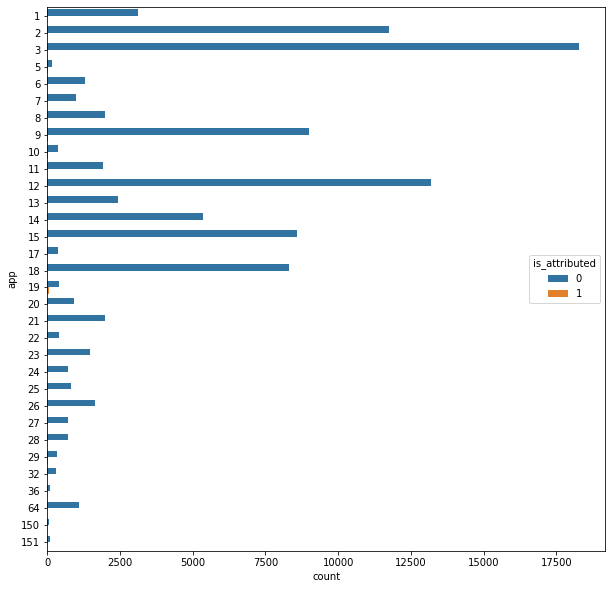

In [57]:
plt.figure(figsize=(10,10))
sns.countplot(y="app", hue="is_attributed", data=frequent_apps)

#Creating datetime variables
#takes in a df, adds date/time based columns to it, and returns the modified df

In [58]:
def timeFeatures(df):
 #Derive new features using the click_time column
 df['datetime'] = pd.to_datetime(df['click_time'])
 df['day_of_week'] = df['datetime'].dt.dayofweek
 df['day_of_year'] = df['datetime'].dt.day_of_year
 df["month"] = df["datetime"].dt.month
 df["hour"] = df["datetime"].dt.hour
 return df
 

In [59]:
#creating new datetime variables and dropping the old ones
data = timeFeatures(data)
data.drop(['click_time','datetime'], axis=1, inplace=True)
data.head()


,ip,app,device,os,channel,attributed_time,is_attributed,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,NaN,0,1,311,11,9
1,105560,25,1,17,259,NaN,0,1,311,11,13
2,101424,12,1,19,212,NaN,0,1,311,11,18
3,94584,13,1,13,477,NaN,0,1,311,11,4
4,68413,12,1,1,178,NaN,0,3,313,11,9


In [60]:
data.dtypes

ip                  int64
app                 int64
device              int64
os                  int64
channel             int64
attributed_time    object
is_attributed       int64
day_of_week         int64
day_of_year         int64
month               int64
hour                int64
dtype: object

In [61]:
data = data.drop('attributed_time',axis=1)

In [62]:
data.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'day_of_week',
       'day_of_year', 'month', 'hour'],
      dtype='object')

In [63]:
data.dtypes

ip               int64
app              int64
device           int64
os               int64
channel          int64
is_attributed    int64
day_of_week      int64
day_of_year      int64
month            int64
hour             int64
dtype: object

In [64]:
#Creates grouping of IP addresses with other features and appends the new features to the df

def grouped_features(df):
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('int64')
    ip_day_hour =df.groupby(['ip','day_of_week','hour']).size().reset_index(name='ip_day_hour').astype('int64')
    ip_hour_channel = df[['ip','hour','channel']].groupby(['ip','hour','channel']).size().reset_index(name='ip_hour_channel').astype('int64')
    ip_hour_device = df.groupby(['ip' ,'hour','device']).channel.count().reset_index(name='ip_hour_device').astype('int64')
     
#merge the new aggregated features with the df

    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip','day_of_week','hour'], how='left')
    
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip','hour','channel'], how='left')
    
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip','hour','os'], how='left')

    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip','hour','device'], how='left')

    del ip_hour_device

    return df
    



    

In [65]:
data.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,0,1,311,11,9
1,105560,25,1,17,259,0,1,311,11,13
2,101424,12,1,19,212,0,1,311,11,18
3,94584,13,1,13,477,0,1,311,11,4
4,68413,12,1,1,178,0,3,313,11,9


Modelling

In [66]:
# create X and y train
 
X = data.drop('is_attributed', axis=1)
y= data[['is_attributed']]

# Split data into train and test/validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 9)
(80000, 1)
(20000, 9)
(20000, 1)


In [67]:
X_train.head()

,ip,app,device,os,channel,day_of_week,day_of_year,month,hour
38823,233473,3,1,15,280,2,312,11,9
78870,77048,12,1,27,259,3,313,11,12
28393,201182,3,1,9,424,2,312,11,12
64349,224329,9,1,62,466,3,313,11,15
23027,79049,2,1,13,237,3,313,11,11


#Download rates in train and test data

In [68]:
y_train.value_counts()

is_attributed
0                79818
1                  182
dtype: int64

The data is imbalanced

In [77]:
#smote
from imblearn.over_sampling import SMOTE
os = SMOTE()


X_train, y_train=os.fit_resample(X_train, y_train)

y_train.value_counts()

is_attributed
0                79818
1                79818
dtype: int64

In [83]:

from xgboost import XGBClassifier
xgbl = XGBClassifier()
xgbl.fit(X_train,y_train)
y_pred = xgbl.predict(X_test)
y_prob = xgbl.predict_proba(X_test)

In [103]:
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

# metrics: AUC
metrics.roc_auc_score(y_test, predictions[:,1])


In [84]:
# AUC Score
metrics.roc_auc_score(y_test, y_prob[:,1])


0.9287441187115454

In [87]:
print(metrics.classification_report(y_test,y_pred))
metrics.confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     19955
           1       0.05      0.80      0.09        45

    accuracy                           0.96     20000
   macro avg       0.52      0.88      0.54     20000
weighted avg       1.00      0.96      0.98     20000



array([[19236,   719],
       [    9,    36]])

In [90]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
bgcl = BaggingClassifier(base_estimator=LogisticRegression())
bgcl.fit(X_train,y_train)
y_pred = bgcl.predict(X_test)
y_prob = bgcl.predict_proba(X_test)

In [91]:
# AUC Score
metrics.roc_auc_score(y_test, y_prob[:,1])

0.8807060330187366

In [92]:
print(metrics.classification_report(y_test,y_pred))
metrics.confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     19955
           1       0.01      0.82      0.02        45

    accuracy                           0.84     20000
   macro avg       0.51      0.83      0.47     20000
weighted avg       1.00      0.84      0.91     20000



array([[16711,  3244],
       [    8,    37]])

In [99]:
# Bagging and Boosting model Comparison
print('The XGBBoost accuracy is {}%'.format(xgbl.score(X_test,y_test)*100))
print('The Bagging classifier accuracy is {}%'.format(round(bgcl.score(X_test,y_test)*100,2)))

The XGBBoost accuracy is 96.36%
The Bagging classifier accuracy is 83.74%


In [101]:
#feature importance 
importance = dict(zip(X_train.columns,xgbl.feature_importances_))
importance

{'ip': 0.096191265,
 'app': 0.41311395,
 'device': 0.24457115,
 'os': 0.045237575,
 'channel': 0.06710865,
 'day_of_week': 0.095213674,
 'day_of_year': 0.0,
 'month': 0.0,
 'hour': 0.038563736}